In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user10\Anaconda3\envs\P

In [2]:
#normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm
#scale back to the true range
def true_range(df, x):
    X = (x * (df['mid1'].max() - df['mid1'].min())) + df['mid1'].min()
    return X
#rolling windows
def train_windows(df, ref_day=10, predict_day=5):
    X_train, Y_train = [], []
    for i in range(int(df.shape[0] / 5 - 2)):
        #扣掉response
        #記得最後一行要放response
        #if i == df.shape[0]-predict_day-ref_day -1:
        #    X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        #    Y_train.append(np.array(df.iloc[i+ref_day:]["mid1"]))
        #else:  
        X_train.append(np.array(df.iloc[i * predict_day: predict_day * (i + 2),:-1]))
        Y_train.append(np.array(df.iloc[(i+2) * predict_day: (i+3) * predict_day]["mid1"]))
    return np.array(X_train), np.array(Y_train)
#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    #10 -> X shape
    model.add(Dense(10,activation='linear'))
    #5 -> Y shape
    model.add(Dense(5,activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)

In [136]:
df = pd.read_csv('./data/3406_2.csv')
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
#1 tick
df['da1_dt_1'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt_1'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt_1'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt_1'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt_1'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt_1'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt_1'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt_1'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt_1'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt_1'] = df['Bid5'] - df['Bid5'].shift(1)
#5 ticks
df['da1_dt_5'] = df['Ask1'] - df['Ask1'].shift(5)
df['da2_dt_5'] = df['Ask2'] - df['Ask2'].shift(5)
df['da3_dt_5'] = df['Ask3'] - df['Ask3'].shift(5)
df['da4_dt_5'] = df['Ask4'] - df['Ask4'].shift(5)
df['da5_dt_5'] = df['Ask5'] - df['Ask5'].shift(5)
df['db1_dt_5'] = df['Bid1'] - df['Bid1'].shift(5)
df['db2_dt_5'] = df['Bid2'] - df['Bid2'].shift(5)
df['db3_dt_5'] = df['Bid3'] - df['Bid3'].shift(5)
df['db4_dt_5'] = df['Bid4'] - df['Bid4'].shift(5)
df['db5_dt_5'] = df['Bid5'] - df['Bid5'].shift(5)
##10 ticks
df['da1_dt_10'] = df['Ask1'] - df['Ask1'].shift(10)
df['da2_dt_10'] = df['Ask2'] - df['Ask2'].shift(10)
df['da3_dt_10'] = df['Ask3'] - df['Ask3'].shift(10)
df['da4_dt_10'] = df['Ask4'] - df['Ask4'].shift(10)
df['da5_dt_10'] = df['Ask5'] - df['Ask5'].shift(10)
df['db1_dt_10'] = df['Bid1'] - df['Bid1'].shift(10)
df['db2_dt_10'] = df['Bid2'] - df['Bid2'].shift(10)
df['db3_dt_10'] = df['Bid3'] - df['Bid3'].shift(10)
df['db4_dt_10'] = df['Bid4'] - df['Bid4'].shift(10)
df['db5_dt_10'] = df['Bid5'] - df['Bid5'].shift(10)
#1 tick
df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
#5 ticks
df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
#10 ticks
df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#drop nan
df = df.dropna()
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
#df = df.drop(['b43_diff_abs'], axis = 1)
#df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [137]:
#3/23 3/24 data有缺值 -> drop
df = df[df['TxTime'] != '2020-03-23']
df = df[df['TxTime'] != '2020-03-24']
df = df.reset_index(drop = True)
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)

# EDA

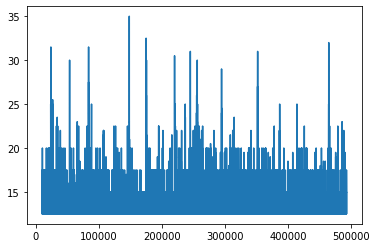

In [151]:
plt.plot(df['p_acc_diff'].iloc[10000:])

In [187]:
#drop outliers(ask1~5 may be 0)
df['p_acc_diff'].sort_values().head(581)

2608   -1214.5
2544   -1214.5
2543   -1214.5
2542   -1214.5
2541   -1214.5
         ...  
2908    -393.5
2918    -393.5
2917    -393.5
2916    -393.5
2914    -393.5
Name: p_acc_diff, Length: 581, dtype: float64

In [190]:
p_acc_diff = df['p_acc_diff'].sort_values().head(581).index.tolist()
df_p_acc_diff = df['p_acc_diff'].drop(p_acc_diff)
df_mid = df['mid1'].drop(p_acc_diff)

In [189]:
df_p_acc_diff

0         16.5
1         20.0
2         20.0
3         17.0
4         17.0
          ... 
493215    12.5
493216    12.5
493217    12.5
493218    12.5
493219    15.0
Name: p_acc_diff, Length: 492639, dtype: float64

In [191]:
df_mid

0         397.50
1         397.25
2         397.25
3         396.75
4         396.75
           ...  
493215    465.75
493216    465.75
493217    465.75
493218    465.75
493219    466.00
Name: mid1, Length: 492639, dtype: float64

In [193]:
np.corrcoef(df_p_acc_diff, df_mid)

array([[ 1.00000000e+00, -6.26947471e-04],
       [-6.26947471e-04,  1.00000000e+00]])

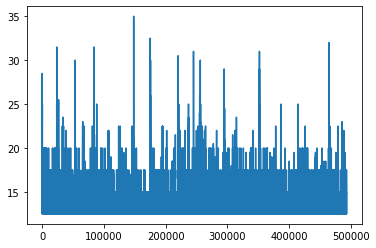

In [194]:
plt.plot(df_p_acc_diff)

In [162]:
df.iloc[2540:2600][['Ask1', 'Ask2', 'Ask3', 'Ask4', 'Ask5']] 

,Ask1,Ask2,Ask3,Ask4,Ask5
2540,407.5,408.0,0.0,0.0,0.0
2541,407.5,408.0,0.0,0.0,0.0
2542,407.5,408.0,0.0,0.0,0.0
2543,407.5,408.0,0.0,0.0,0.0
2544,407.5,408.0,0.0,0.0,0.0
2545,407.5,408.0,0.0,0.0,0.0
2546,407.5,408.0,0.0,0.0,0.0
2547,407.5,408.0,0.0,0.0,0.0
2548,407.5,408.0,0.0,0.0,0.0
2549,407.5,408.0,0.0,0.0,0.0


In [163]:
df.iloc[2540:2600][['Bid1', 'Bid2', 'Bid3', 'Bid4', 'Bid5']] 

,Bid1,Bid2,Bid3,Bid4,Bid5
2540,407.0,406.5,406.0,405.5,405.0
2541,407.0,406.5,406.0,405.5,405.0
2542,407.0,406.5,406.0,405.5,405.0
2543,407.0,406.5,406.0,405.5,405.0
2544,407.0,406.5,406.0,405.5,405.0
2545,407.0,406.5,406.0,405.5,405.0
2546,407.0,406.5,406.0,405.5,405.0
2547,407.0,406.5,406.0,405.5,405.0
2548,407.0,406.5,406.0,405.5,405.0
2549,407.0,406.5,406.0,405.5,405.0


In [245]:
np.sum(df_train['p_acc_diff'] > 25)

351

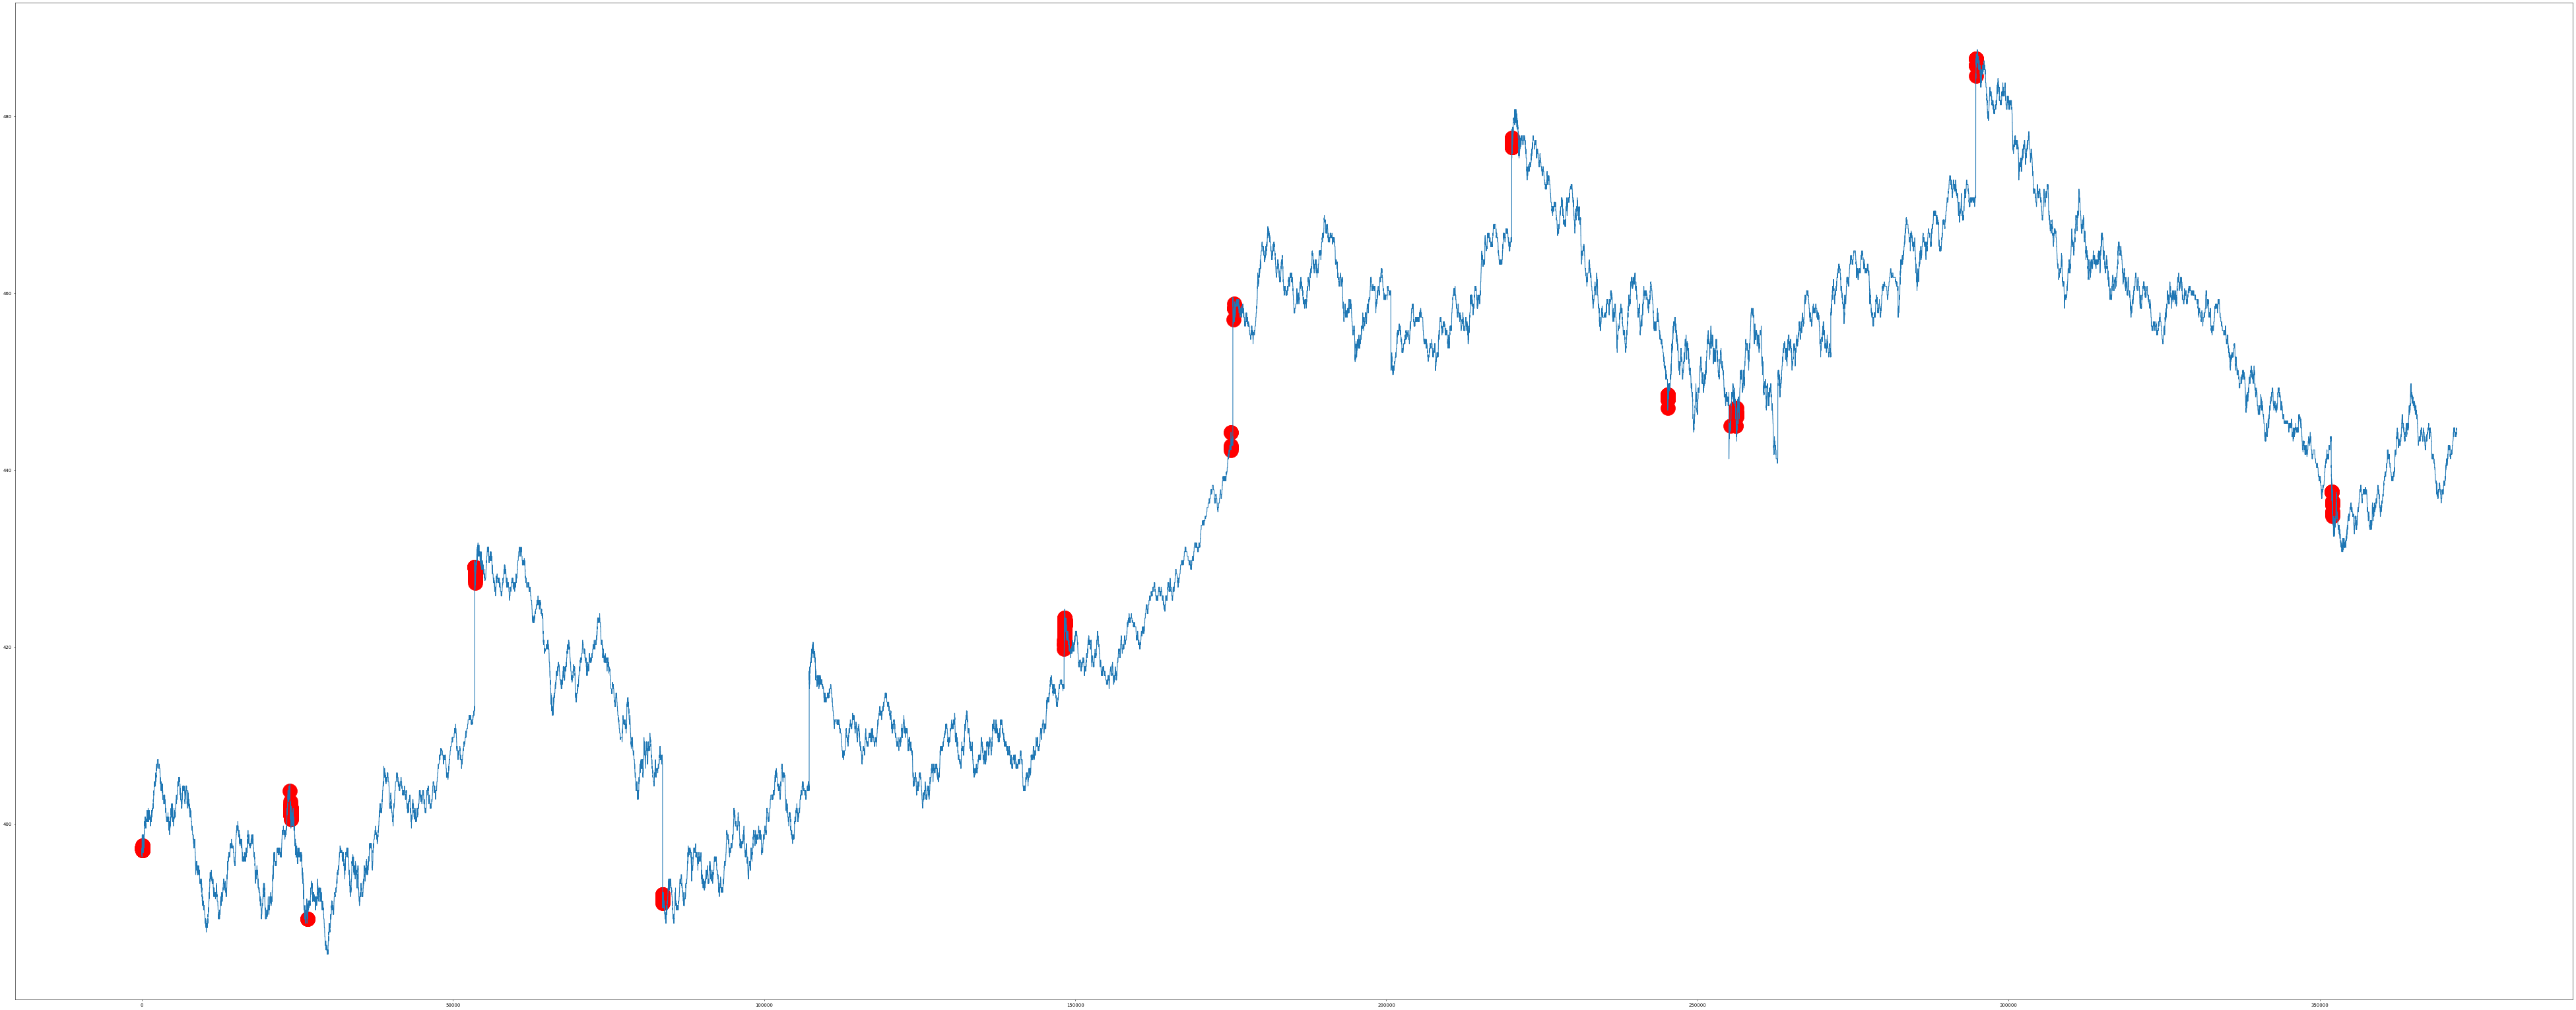

In [244]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_train['mid1'])
plt.scatter(df_train[df_train['p_acc_diff'] > 25].index.tolist(), df_train['mid1'][df_train[df_train['p_acc_diff'] > 25].index.tolist()], color = ['red'], s = 1000)

In [243]:
np.sum(df_train['pred_return'] > 0.0025)

61

In [237]:
np.sum(df_train['pred_return'] < -0.001)

32

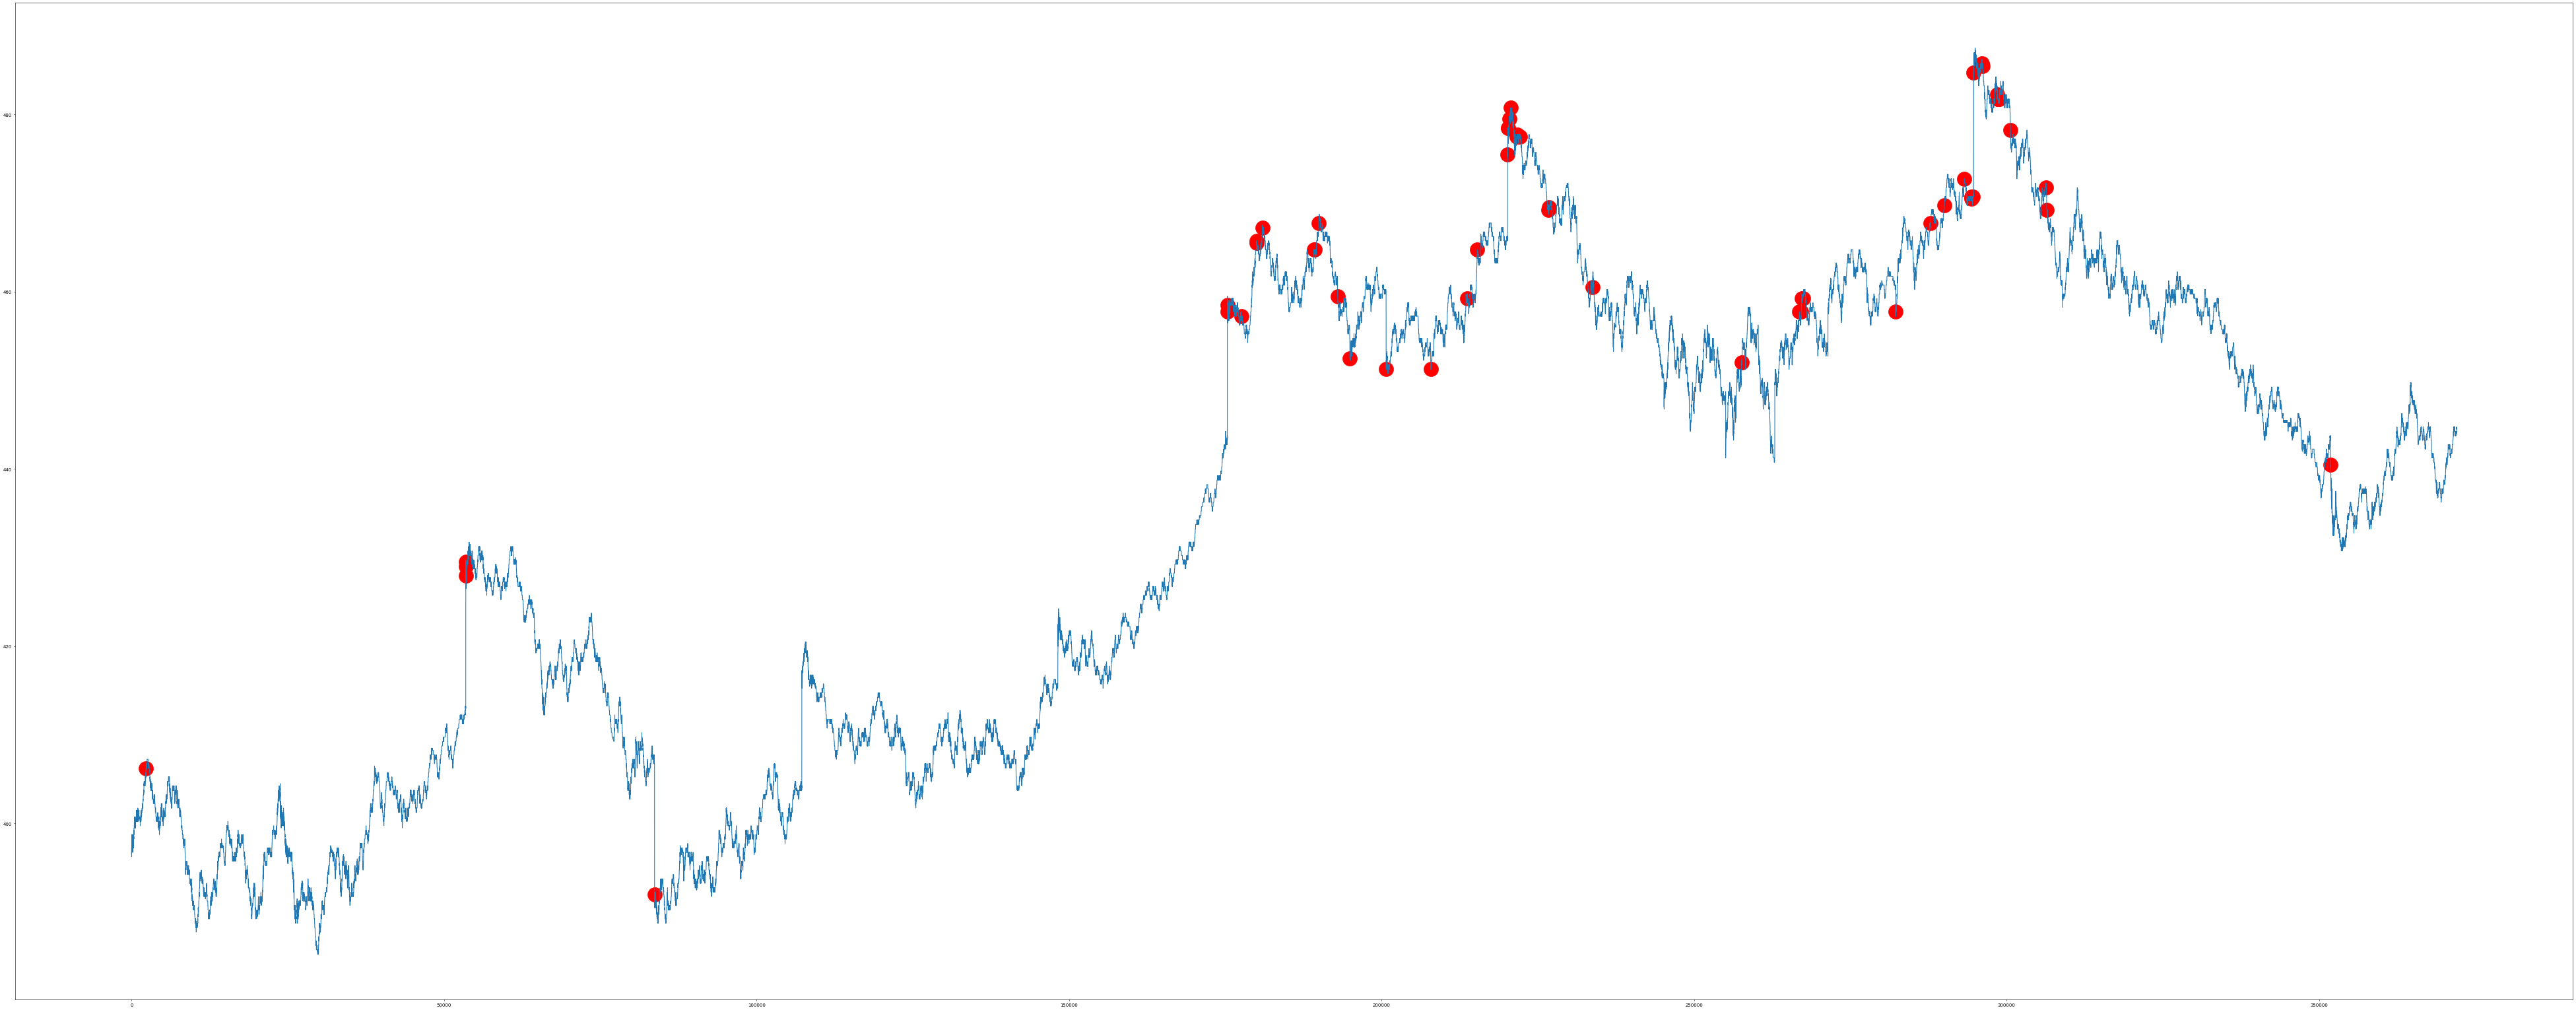

In [240]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_train['mid1'])
plt.scatter(df_train[df_train['pred_return'] > 0.0025].index.tolist(), df_train['mid1'][df_train[df_train['pred_return'] > 0.0025].index.tolist()], color = ['red'], s = 1000)

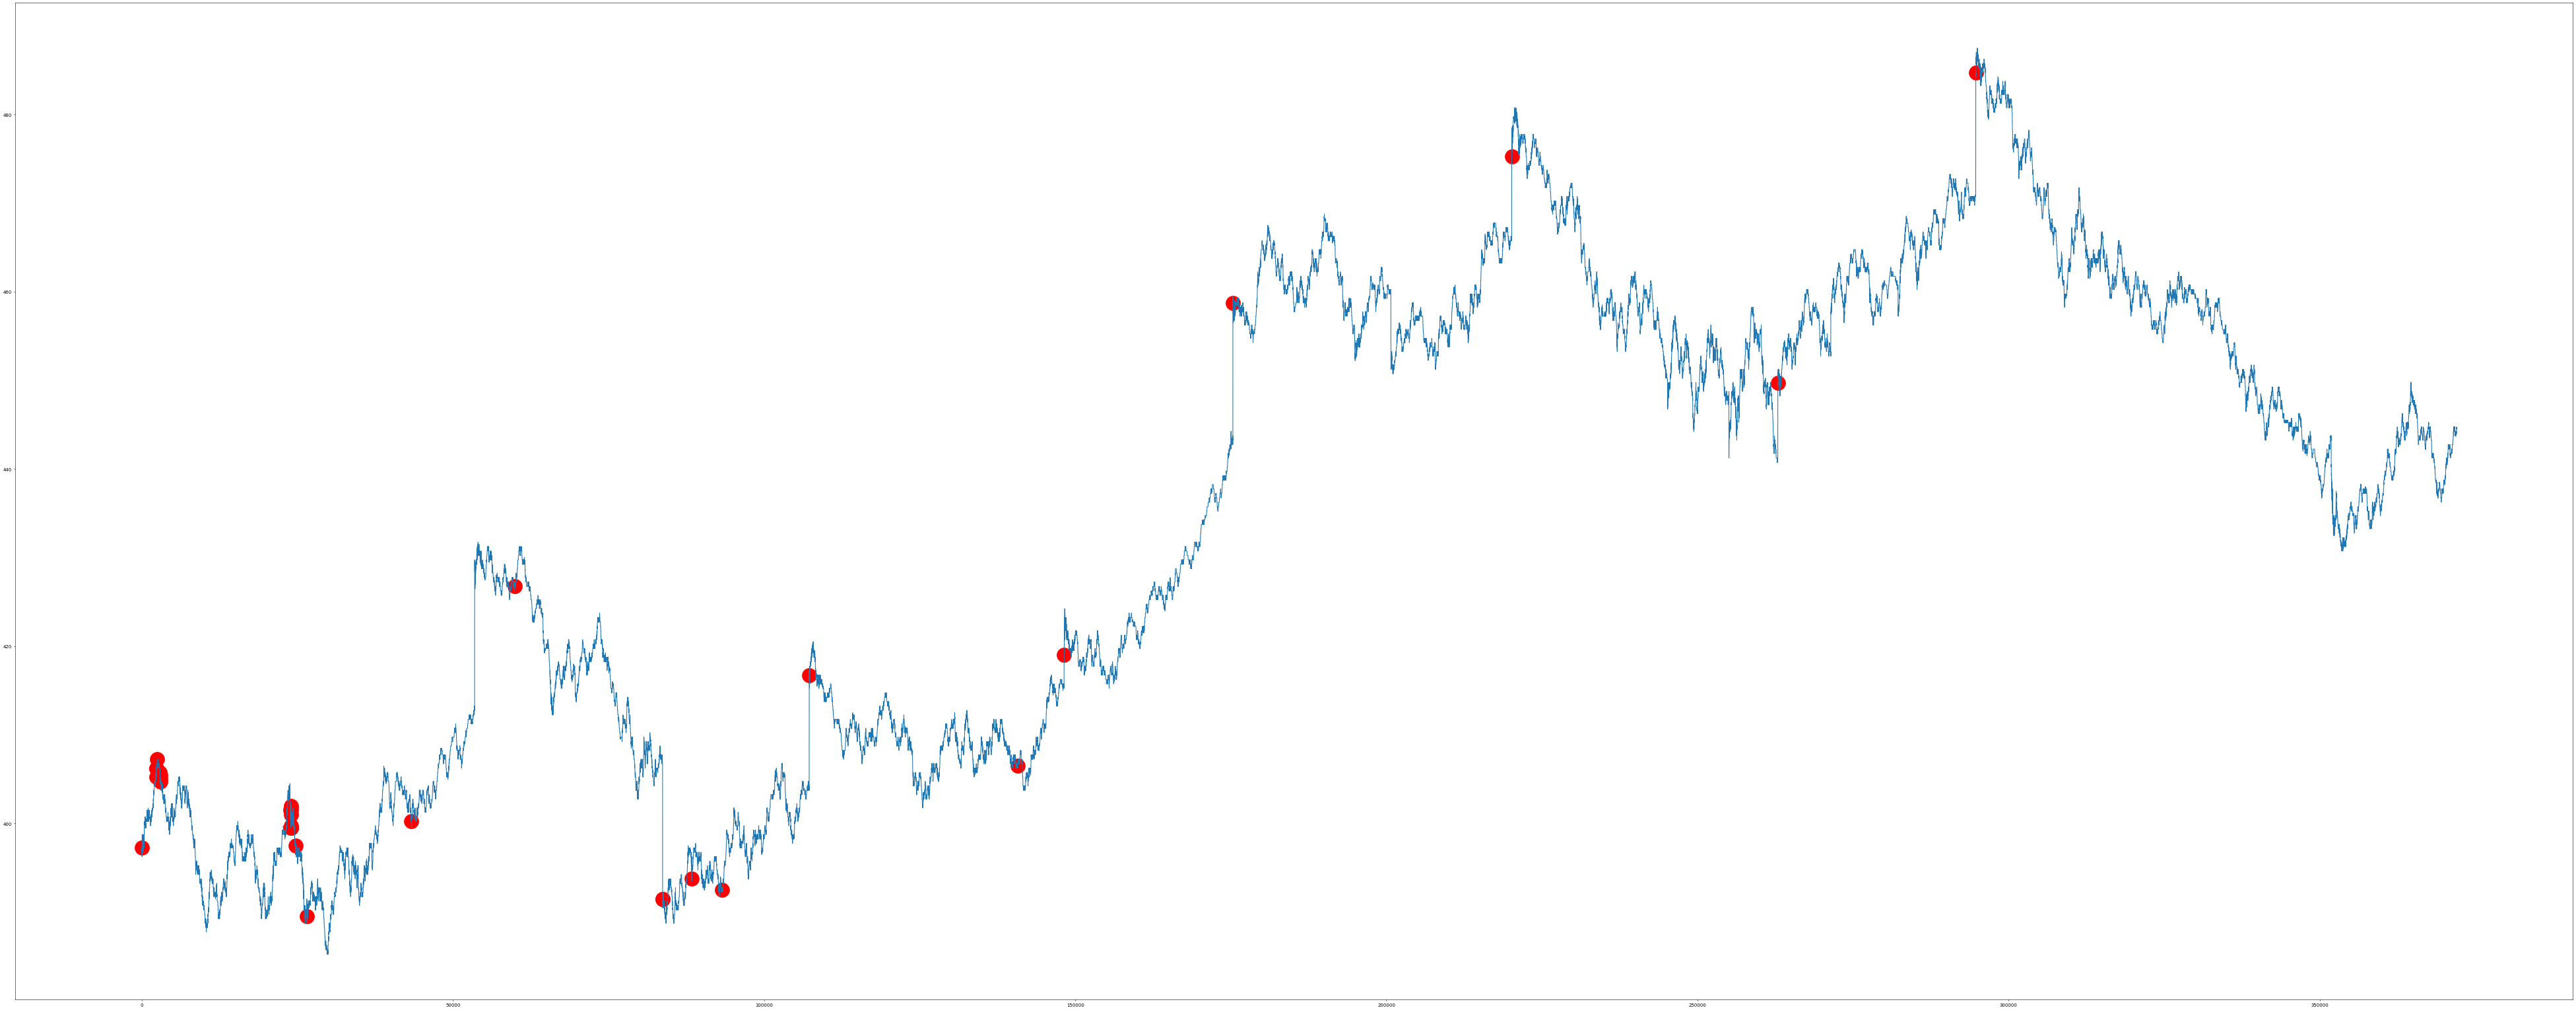

In [241]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_train['mid1'])
plt.scatter(df_train[df_train['pred_return'] < -0.001].index.tolist(), df_train['mid1'][df_train[df_train['pred_return'] < -0.001].index.tolist()], color = ['red'], s = 1000)

# strategy

In [229]:
train_5t = pd.read_csv('./data/train_5t_2.csv')
test_5t = pd.read_csv('./data/test_5t_2.csv')

In [230]:
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#test
df_test = df.iloc[372025: ]
#為了可以被5整除
df_train = df.iloc[0:372025]
#1~10 pred 11, hence start from 11
df_train = df_train.iloc[10:, :]
df_test = df_test.iloc[10:, :]
#reset index
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [231]:
#calculate pred return
df_train['pred_mid'] = train_5t[['0']]
#df_train['mid_shift'] = df_train['pred_mid'].shift(1)
df_test['pred_mid'] = test_5t[['0']]

In [232]:
df_train['mid_5_shift'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
for i in range(int(int(len(df_train)) / 5)):
    df_train['mid_5_shift'].iloc[5 * i] = df_train['pred_mid'].iloc[(5 * i) + 4]
df_train['pred_return'] = df_train['mid_5_shift'] / df_train['pred_mid'] - 1
for i in range(len(df_train)):
    if df_train['pred_return'].iloc[i] == -1:
        df_train['pred_return'].iloc[i] = 0

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [233]:
df_test['mid_5_shift'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
for i in range(int(int(len(df_test)) / 5)):
    df_test['mid_5_shift'].iloc[5 * i] = df_test['pred_mid'].iloc[(5 * i) + 4]
df_test['pred_return'] = df_test['mid_5_shift'] / df_test['pred_mid'] - 1
for i in range(len(df_test)):
    if df_test['pred_return'].iloc[i] == -1:
        df_test['pred_return'].iloc[i] = 0

In [132]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015], [-0.001, -0.0015], [-0.01, -0.015]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.001, -0.001, -0.01),
 (0.001, -0.001, -0.015),
 (0.001, -0.0015, -0.01),
 (0.001, -0.0015, -0.015),
 (0.0015, -0.001, -0.01),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.0015, -0.01),
 (0.0015, -0.0015, -0.015)]

In [234]:
df_train['short_qty'] = (df_train['AskQty1'] - df_train['BidQty1']) / (df_train['AskQty1'] + df_train['BidQty1'])

In [235]:
df_train['long_qty'] = (df_train['BidQty1'] - df_train['AskQty1']) / (df_train['AskQty1'] + df_train['BidQty1'])

In [118]:
df_train

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,mid1,equity_value,unrealized,holding,pred_mid,mid_5_shift,pred_return,side,long_qty,short_qty
0,397.0,1,2,396.5,397.0,3,6,396.0,398.0,20,...,396.75,0.0,0.0,0.0,395.92853,396.09964,0.000432,0.0,-0.200000,0.200000
1,397.0,1,2,396.5,397.0,2,6,396.0,398.0,20,...,396.75,0.0,0.0,0.0,398.42273,0.00000,0.000000,0.0,0.000000,0.000000
2,396.5,2,6,396.0,397.0,2,40,395.0,398.0,20,...,396.50,0.0,0.0,0.0,394.70728,0.00000,0.000000,0.0,0.500000,-0.500000
3,397.0,2,6,396.0,397.0,0,40,395.0,398.0,20,...,396.50,0.0,0.0,0.0,395.67096,0.00000,0.000000,0.0,1.000000,-1.000000
4,398.0,20,6,396.0,397.0,0,40,395.0,398.0,20,...,396.50,0.0,0.0,0.0,396.09964,0.00000,0.000000,0.0,1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372010,444.5,1,7,444.0,445.0,26,11,443.5,445.5,9,...,444.50,0.0,0.0,0.0,444.28940,444.68720,0.000895,0.0,-0.575758,0.575758
372011,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,444.50,0.0,0.0,0.0,444.96228,0.00000,0.000000,0.0,-0.529412,0.529412
372012,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,444.50,0.0,0.0,0.0,444.60876,0.00000,0.000000,0.0,-0.529412,0.529412
372013,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,444.50,0.0,0.0,0.0,444.09310,0.00000,0.000000,0.0,-0.529412,0.529412


In [126]:
(df_train['long_qty'] > 0.9).sum()

10933

In [127]:
(df_train['short_qty'] > 0.9).sum()

9730

In [128]:
#原始策略挑出來的一組，丟進來這個策略看看會不會比較好
#paras = [(0.001, -0.0025, -0.025)]

In [133]:
#adding hard stop 
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            #long side
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            #short side
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1) and (df['short_qty'].iloc[i-1] > 0.9): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1) and (df['long_qty'].iloc[i-1] > 0.9): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0) and (df['long_qty'].iloc[i-1] > 0.9):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1 and (df['short_qty'].iloc[i-1] > 0.9):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

In [135]:
#原始策略挑出來的一組，丟進來這個策略報酬、勝率降低了
equity_value_1.columns = paras
equity_value_1

,"(0.001, -0.001, -0.01)","(0.001, -0.001, -0.015)","(0.001, -0.0015, -0.01)","(0.001, -0.0015, -0.015)","(0.0015, -0.001, -0.01)","(0.0015, -0.001, -0.015)","(0.0015, -0.0015, -0.01)","(0.0015, -0.0015, -0.015)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
372010,-0.197404,-0.119960,-0.197404,-0.119960,-0.215841,-0.169939,-0.215841,-0.169939
372011,-0.197404,-0.119960,-0.197404,-0.119960,-0.215841,-0.169939,-0.215841,-0.169939
372012,-0.197404,-0.119960,-0.197404,-0.119960,-0.215841,-0.169939,-0.215841,-0.169939
372013,-0.197404,-0.119960,-0.197404,-0.119960,-0.215841,-0.169939,-0.215841,-0.169939


In [131]:
performance(equity_value_1[['equity_value']], transaction_history1[(0.001, -0.0025, -0.025)])

return: -0.07814890634651273
std: 0.04091910878495492
sharp ratio: -2.0369189071184834
trades: 22.0
odds ratio: 0.45454545454545453
mdd: 0.178077701981957
skewness: -0.4415668060926584


(-0.07814890634651273,
 0.04091910878495492,
 -2.0369189071184834,
 22.0,
 0.45454545454545453,
 0.178077701981957,
 -0.4415668060926584)

In [104]:
equity_value_1.columns = paras
equity_value_1

,"(0.001, -0.001, -0.01)","(0.001, -0.001, -0.015)","(0.001, -0.0015, -0.01)","(0.001, -0.0015, -0.015)","(0.0015, -0.001, -0.01)","(0.0015, -0.001, -0.015)","(0.0015, -0.0015, -0.01)","(0.0015, -0.0015, -0.015)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
372010,-0.146071,-0.085165,-0.154643,-0.093726,-0.246401,-0.121117,-0.228643,-0.161664
372011,-0.146071,-0.085165,-0.154643,-0.093726,-0.246401,-0.121117,-0.228643,-0.161664
372012,-0.146071,-0.085165,-0.154643,-0.093726,-0.246401,-0.121117,-0.228643,-0.161664
372013,-0.146071,-0.085165,-0.154643,-0.093726,-0.246401,-0.121117,-0.228643,-0.161664


In [105]:
for i in paras:
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.001, -0.001, -0.01)
return: -0.12452932940173109
std: 0.05562988819859031
sharp ratio: -2.3320077318619976
trades: 46.0
odds ratio: 0.30434782608695654
mdd: 0.21994142140000753
skewness: -1.1451542522823266
(0.001, -0.001, -0.015)
return: -0.06007522938679927
std: 0.04335527670039332
sharp ratio: -1.5055890390893778
trades: 37.0
odds ratio: 0.35135135135135137
mdd: 0.18741892920740966
skewness: -1.3327936943576313
(0.001, -0.0015, -0.01)
return: -0.13310148368522992
std: 0.054850407416243294
sharp ratio: -2.5214303812859846
trades: 43.0
odds ratio: 0.3023255813953488
mdd: 0.2075696854091921
skewness: -1.2317725222028484
(0.001, -0.0015, -0.015)
return: -0.06863649113604109
std: 0.0427441124746924
sharp ratio: -1.7274072816404276
trades: 34.0
odds ratio: 0.35294117647058826
mdd: 0.18741892920740966
skewness: -1.3776826834728704
(0.0015, -0.001, -0.01)
return: -0.24640111180590632
std: 0.0698302604952662
sharp ratio: -3.6030384251962286
trades: 37.0
odds ratio: 0.1891891891891892
mdd:

In [90]:
#odds ratio下降